# Data Exploration
> ETL - Data exploration is the process of examining and visualizing your data before modeling. It helps you understand the structure, patterns, distributions, and potential issues (like missing values or outliers) in your dataset. This step guides data cleaning, feature engineering, and model selection by revealing important insights about the data.

## Initialization

In [1]:
import pandas as pd
import numpy as np
import os
import rich

## Load Data

In [2]:
input_folder = "../.local/analysis_pipeline/data_etl"
model_data = pd.read_parquet(f"{input_folder}/model_data.parquet")
print( model_data.shape )
model_data.head(5)

(60392, 19)


,pol_number,pol_eff_dt,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,claim_office,numclaims,claimcst0,annual_premium,agecat2,pol_year,pol_quarter,veh_cnt
0,64080188,2017-07-10,M,2.0,1989-01-04,631.0,B,140.9,4,TRUCK,0.924,None,0,0.000000,716.53,5.0,2017,3,1
1,18917133,2017-07-31,M,2.0,1985-06-21,531.0,C,136.5,3,HBACK,1.430,B,1,583.010876,716.53,5.0,2017,3,1
2,82742606,2017-02-01,M,6.0,1942-07-25,838.0,D,88.8,3,SEDAN,1.100,D,1,159.375757,716.53,1.0,2017,1,1
3,43601997,2017-10-17,M,5.0,1959-06-08,835.0,E,NaN,2,SEDAN,2.090,None,0,0.000000,716.53,2.0,2017,4,1
4,58746861,2017-04-13,F,4.0,1967-05-16,748.0,C,123.0,3,HBACK,0.803,C,1,143.555642,716.53,3.0,2017,2,1


In [3]:
inference_data = pd.read_parquet(f"{input_folder}/inference_data.parquet")
print( inference_data.shape )
inference_data.head(5)

(7464, 13)


,quote_number,gender,agecat,date_of_birth,credit_score,area,traffic_index,veh_age,veh_body,veh_value,agecat2,veh_cnt,pol_year
0,29323463,F,4.0,1968-04-14,750.0,C,124.5,2,HBACK,1.100,3.0,1,2018
1,16732441,M,2.0,1984-10-04,567.0,F,NaN,3,STNWG,2.079,5.0,1,2018
2,68744228,M,4.0,1962-11-30,378.0,D,111.4,3,HDTOP,2.354,3.0,1,2018
3,30875047,F,3.0,1973-05-17,807.0,E,NaN,4,UTE,1.969,4.0,1,2018
4,37049210,M,6.0,1945-10-02,844.0,C,111.0,1,HBACK,1.969,1.0,1,2018


## Target Variable Analysis
### Create target variable

In [4]:
# Rename columns for clarity and consistency
model_data = model_data.rename(columns={'numclaims': 'claim_cnt'})
model_data = model_data.rename(columns={'claimcst0': 'claim_amt'})

# Create a new column 'claim_sev' (claim severity) as claim_amt divided by claim_cnt
# If claim_cnt is zero, set claim_sev to NaN to avoid division by zero
model_data['claim_sev'] = model_data.apply(
    lambda row: row['claim_amt'] / row['claim_cnt'] if row['claim_cnt'] != 0 else np.nan,
    axis=1
)

### Visualize target variables
#### Visualize claim count/frequency variable

Mean of claim_cnt: 0.214
Variance of claim_cnt: 0.305


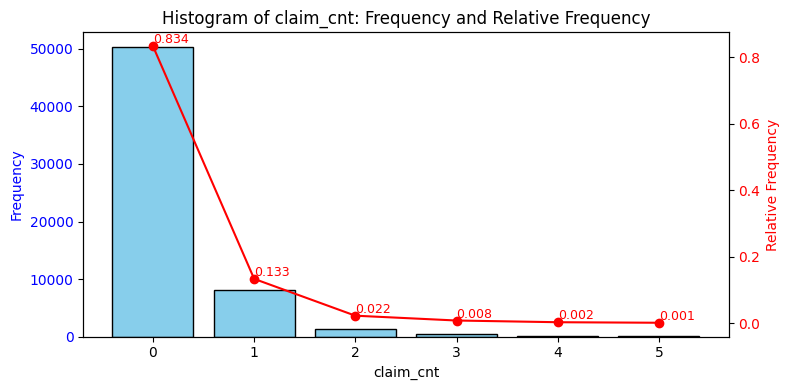

In [5]:
# Plot a histogram of 'claim_cnt' showing both frequency and relative frequency, with annotations
import matplotlib.pyplot as plt
import numpy as np

# Print the mean and variance of the claim_cnt column
mean_claim_cnt = model_data['claim_cnt'].mean()
var_claim_cnt = model_data['claim_cnt'].var()
print(f"Mean of claim_cnt: {mean_claim_cnt:.3f}")
print(f"Variance of claim_cnt: {var_claim_cnt:.3f}")

# Show the claim count distribution
counts, bins = np.histogram(model_data['claim_cnt'], bins=range(int(model_data['claim_cnt'].min()), int(model_data['claim_cnt'].max())+2))
rel_freq = counts / counts.sum()

fig, ax1 = plt.subplots(figsize=(8,4))

# Frequency histogram
ax1.bar(bins[:-1], counts, width=0.8, color='skyblue', edgecolor='black', label='Frequency')
ax1.set_xlabel('claim_cnt')
ax1.set_ylabel('Frequency', color='blue')
ax1.tick_params(axis='y', labelcolor='blue')

# Relative frequency (secondary axis)
ax2 = ax1.twinx()
ax2.plot(bins[:-1], rel_freq, 'o-', color='red', label='Relative Frequency')
ax2.set_ylabel('Relative Frequency', color='red')
ax2.tick_params(axis='y', labelcolor='red')

# Annotate relative frequency values next to red dots
for x, y in zip(bins[:-1], rel_freq):
    ax2.text(x, y, f'{y:.3f}', color='red', fontsize=9, ha='left', va='bottom')

plt.title('Histogram of claim_cnt: Frequency and Relative Frequency')
fig.tight_layout()
plt.show()

#### Visualize claim severity

Gamma Distribution: Kurtosis and Mean-Variance Relationship
- **Kurtosis**: The excess kurtosis of a Gamma distribution with shape parameter $k$ is $6/k$. The total kurtosis is $6/k + 3$.
- **Mean and Variance**: For shape $k$ and scale $\theta$:
    - Mean: $\mu = k\theta$
    - Variance: $\sigma^2 = k\theta^2$
    - So, $\text{Variance} = \text{Mean} \times \theta$

Mean of claim_sev: 3073.604
Variance of claim_sev: 34498627.299
Skewness of claim_sev: 4.979
Kurtosis of claim_sev: 33.045


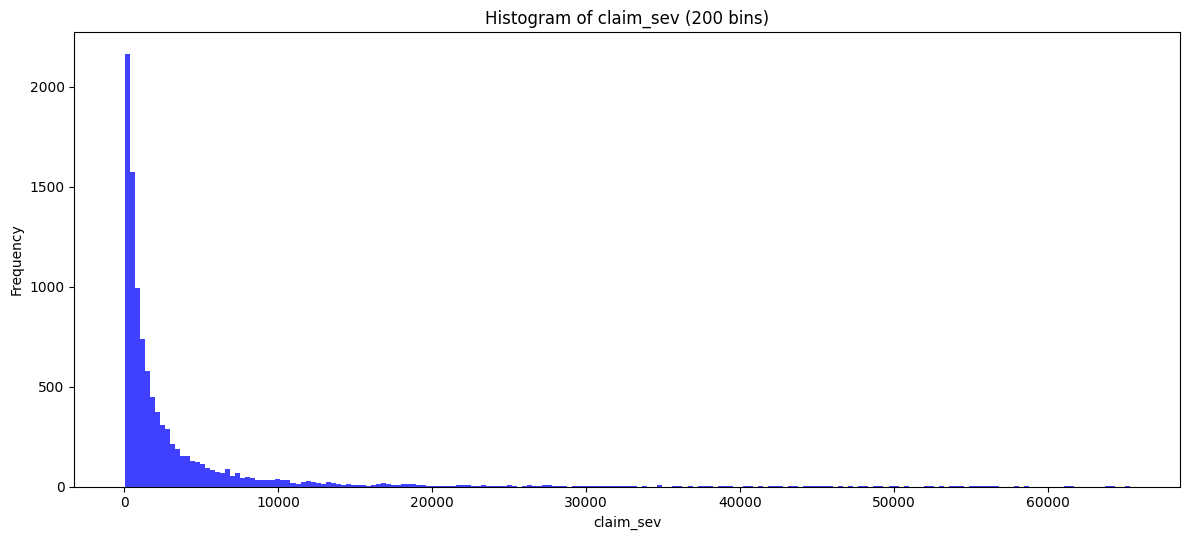

In [6]:
# Compute mean, variance, skewness, and kurtosis of claim_sev
mean_sev = model_data['claim_sev'].dropna().mean()
var_sev = model_data['claim_sev'].dropna().var()
skew_sev = model_data['claim_sev'].dropna().skew()
kurt_sev = model_data['claim_sev'].dropna().kurtosis()
print(f"Mean of claim_sev: {mean_sev:.3f}")
print(f"Variance of claim_sev: {var_sev:.3f}")
print(f"Skewness of claim_sev: {skew_sev:.3f}")
print(f"Kurtosis of claim_sev: {kurt_sev:.3f}")

# Plot a histogram of 'claim_sev' with 100 bins
import matplotlib.pyplot as plt
plt.figure(figsize=(12,5.5))
plt.hist(model_data['claim_sev'].dropna(), bins=200, facecolor='blue', alpha=0.75)
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

Cap severity variable

Kurtosis of original claim_sev: 33.028
Kurtosis of capped claim_sev: 23.228
After capping at the 99.5 percentile (cap value: 44000.0), the % of total capped claim_sev to the total original claim_sev is 98.6%.


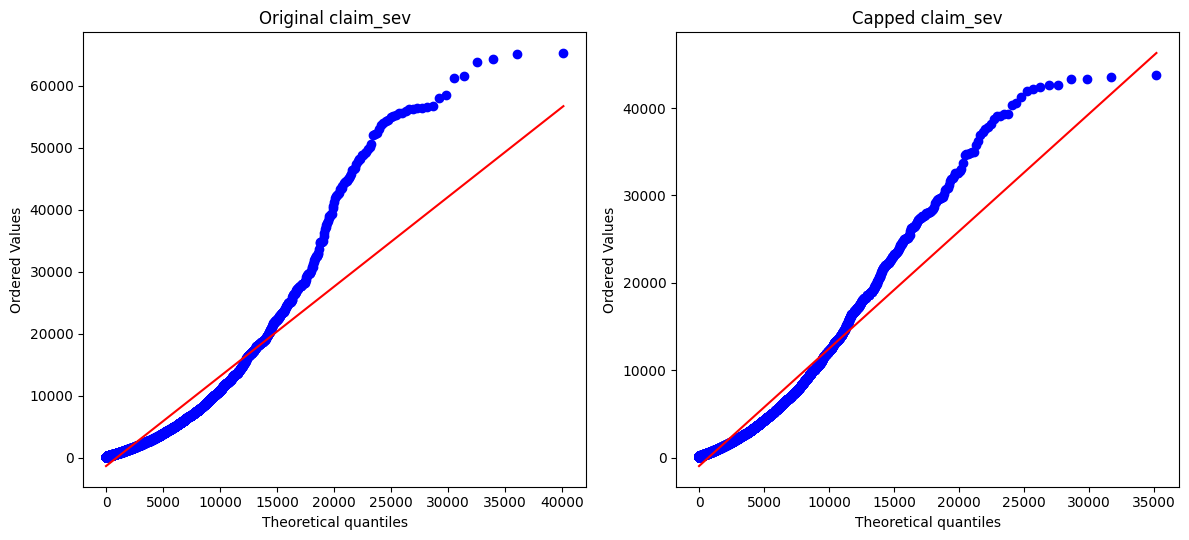

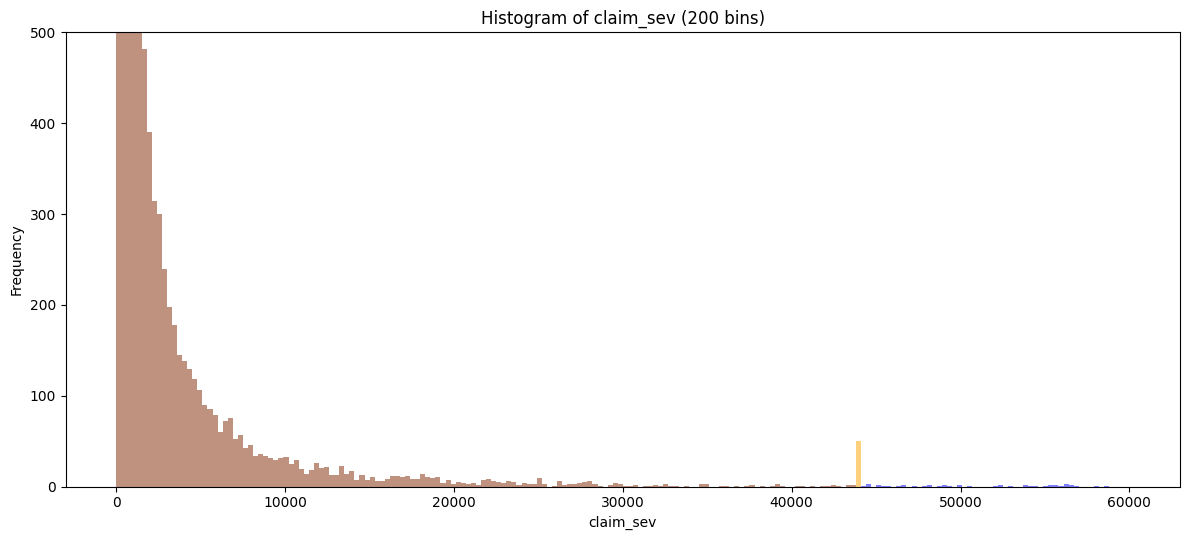

In [7]:
# QQ plot for claim_sev before and after capping at a specified percentile
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
from matplotlib.pylab import rcParams

# Set capping percentile and calculate cap value
cap_percentile = 99.5
cap_value = 1000 * round(np.nanpercentile(model_data['claim_sev'], cap_percentile) / 1000, 0)

# Cap the claim_sev variable
model_data['claim_sev_capped'] = model_data['claim_sev'].clip(upper=cap_value)

# Calculate share of capped to original
share_incurred = model_data['claim_sev_capped'].sum() / model_data['claim_sev'].sum()

# Print kurtosis and share information
print(f"Kurtosis of original claim_sev: {stats.kurtosis(model_data['claim_sev'].dropna()):.3f}")
print(f"Kurtosis of capped claim_sev: {stats.kurtosis(model_data['claim_sev_capped'].dropna()):.3f}")
print(f"After capping at the {cap_percentile} percentile (cap value: {cap_value}), the % of total capped claim_sev to the total original claim_sev is {100 * share_incurred:.1f}%.")

# Prepare data for QQ plots
y_ori = model_data['claim_sev'].dropna()
y_capped = model_data.loc[model_data['claim_sev']<=cap_value, 'claim_sev_capped'].dropna()

# Fit gamma distributions
sparams_ori = stats.gamma.fit(y_ori, floc=0)
sparams_capped = stats.gamma.fit(y_capped, floc=0)

# Plot QQ plots
rcParams['figure.figsize'] = 12, 5.5
fig, (ax1, ax2) = plt.subplots(1, 2)
stats.probplot(y_ori, sparams_ori, dist='gamma', plot=ax1)
ax1.set_title('Original claim_sev')
stats.probplot(y_capped, sparams_capped, dist='gamma', plot=ax2)
ax2.set_title('Capped claim_sev')
plt.tight_layout()
plt.show()

# Plot a histogram of 'claim_sev' and 'claim_sev_capped' with 200 bins
import matplotlib.pyplot as plt
rcParams['figure.figsize'] = 12, 5.5
plt.hist(model_data['claim_sev'].dropna(), bins=200, range=[0, 60000], facecolor='blue', alpha=0.5, label='Original')
plt.hist(model_data['claim_sev_capped'].dropna(), bins=200, range=[0, 60000], facecolor='orange', alpha=0.5, label='Capped')
plt.xlabel('claim_sev')
plt.ylabel('Frequency')
plt.ylim([0,500])
plt.title('Histogram of claim_sev (200 bins)')
plt.tight_layout()
plt.show()

#### Compute total claim amount

In [8]:
# Compute the capped claim amount
model_data['claim_amt_capped'] = model_data.apply(
    lambda row: row['claim_cnt'] * row['claim_sev_capped'] if row['claim_cnt']!=0 else 0, 
    axis=1
)

# Print the total original and capped claim amounts
print(f"Average original claim amount: {model_data['claim_amt'].mean():.3f}")
print(f"Average capped claim amount: {model_data['claim_amt_capped'].mean():.3f}")
# Print the combined original and capped loss ratios
print(f"Combined original loss ratio: {model_data['claim_amt'].sum() / model_data['annual_premium'].sum():.3f}")
print(f"Combined capped loss ratio: {model_data['claim_amt_capped'].sum() / model_data['annual_premium'].sum():.3f}")

Average original claim amount: 644.876
Average capped claim amount: 637.706
Combined original loss ratio: 0.900
Combined capped loss ratio: 0.890


## Consistency Check
### Create a combined data set for consistency check purpose

In [13]:
# Create predictor list
pred_lst = ['agecat2', 'gender', 'credit_score', 'area', 'traffic_index', 'veh_age', 'veh_body', 'veh_value']
cols = ['pol_year', 'veh_cnt'] + pred_lst

# Concatenate model_data[cols] and inference_data[cols] vertically
combined_expo_pred_data = pd.concat(
    [model_data[cols], 
     inference_data[cols]], 
     axis=0, 
     ignore_index=True
     )
print('Combined data shape:', combined_expo_pred_data.shape)
combined_expo_pred_data.head()

Combined data shape: (67856, 10)


,pol_year,veh_cnt,agecat2,gender,credit_score,area,traffic_index,veh_age,veh_body,veh_value
0,2017,1,5.0,M,631.0,B,140.9,4,TRUCK,0.924
1,2017,1,5.0,M,531.0,C,136.5,3,HBACK,1.430
2,2017,1,1.0,M,838.0,D,88.8,3,SEDAN,1.100
3,2017,1,2.0,M,835.0,E,NaN,2,SEDAN,2.090
4,2017,1,3.0,F,748.0,C,123.0,3,HBACK,0.803


In [ ]:
# input
pred_var = 'agecat2'
exp_var = 'traffic_index'
year_var = 'pol_year'

# construct


## Predictiveness Check

## Variable Reduction